## Dataset Description
- `data.csv`: Contains tweets with labels for training.
- `data_validation.csv`: Used to evaluate the model with unseen data.

# Sentiment Analysis Project

## Introduction and Problem Statement
Sentiment analysis is a key area in machine learning that focuses on analyzing emotions expressed in text. It has significant applications in determining public opinion, customer feedback, and social media analysis
### Submission
- Deadline of submission:
19.08.2024 23:59

In [73]:
import pandas as pd
import numpy as np
import re
import string
import matplotlib.pyplot as plt
import nltk
import numpy.typing as npt
import time
from typing import Self
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from scipy.sparse import csr_matrix
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.svm import LinearSVC
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, confusion_matrix

In [74]:
DATA_SIZE_LOG_REG = 50_000
DATA_SIZE_NAV_BAY = 50_000
DATA_SIZE_SVM = 50_000
DATA_SPLIT_RATIO = 0.1
MAX_FEATURES = 5_000
LAPLACE_SMOOTHING_CONSTANT = 0.0002

## 1. Data Preprocessing

### 1.1 Clean Data
Refine the tweet text by removing elements like URLs, mentions, hashtags, numbers, and special characters. Ensure the text is in lowercase to maintain uniformity.

In [75]:
def clean_tweet(tweet):
    tweet = re.sub(r'http\S+', '', tweet, flags=re.MULTILINE)  # Remove URLs
    tweet = re.sub(r'\b@\w+', '', tweet)  # Remove mentions
    tweet = re.sub(r'#\w+', '', tweet)  # Remove hashtags
    tweet = re.sub(r'\d+', '', tweet)  # Remove numbers
    tweet = re.sub(r'\W+', ' ', tweet)  # Remove special characters
    tweet = re.sub(r'(.)\1{2,}', r'\1', tweet)   # Remove multiple occurences of the same character
    tweet = tweet.lower()  # Convert to lowercase and strip whitespaces
    return tweet


### 1.2 Evaluate Model
Assess the sentiment analysis model’s performance using metrics like accuracy, recall, precision, F1 score, and a confusion matrix.

In [76]:
results = []
def evaluate_model(model_name, model_size, y_true, y_pred, time_meassured, pos_label=1):
    accuracy = accuracy_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred, pos_label=pos_label)
    precision = precision_score(y_true, y_pred, pos_label=pos_label)
    f1 = f1_score(y_true, y_pred, pos_label=pos_label)
    conf_matrix = confusion_matrix(y_true, y_pred)
    
    results.append({
        'model': model_name,
        'model_size' : model_size,
        'accuracy': accuracy,
        'recall': recall,
        'precision': precision,
        'f1_score': f1,
        'confusion_matrix': conf_matrix,
        'time_meassured' : time_meassured
    })

## 2. Logistic Regression
Logistic Regression is a statistical method used for binary classification. It models the probabilities of default classes based on input features using a logistic function. This section demonstrates how to prepare data, transform it into a numerical format suitable for the model, train the logistic regression classifier, and evaluate its performance on sentiment analysis tasks. The goal is to predict whether a tweet has a positive or negative sentiment accurately.
### 2.1 Import Data

Find a way to load the dataset and transform the features `X` (Tweets) and the labels `Y` (positive/negative).

In [77]:
# TODO: load data, transform into numerical features + labels
df = pd.read_csv('data.csv', names=['labels', 'tweets'], header=None, skiprows=1)
# Select the first 10,000 data points
df = df.head(DATA_SIZE_LOG_REG)

# Extract features and labels
X = df['tweets']
y = df['labels']

X = X.apply(clean_tweet)

### 2.2 Prior $p(S)$
Determine the prior probabilities for the categories 'positive' and 'negative' in the dataset using the maximum likelihood (ML) estimate. The ML estimate is calculated as the relative frequency of each category.

The prior distribution $p(S)$ is independent of the message $W$. We will use the maximum likelihood (ML) estimate for a categorical distribution, which is the relative frequency of the categories among the dataset.
\begin{align}
p(S = \text{positive})_{ML} &= \cfrac{\text{\# tweets that are positive}}{\text{\# tweets}}\\
p(S = \text{negative})_{ML} &= 1 - p(S = \text{negative})
\end{align}

### 2.3 Estimate Distribution


Estimate $p(S)$. Display the estimated distribution in a bar chart.

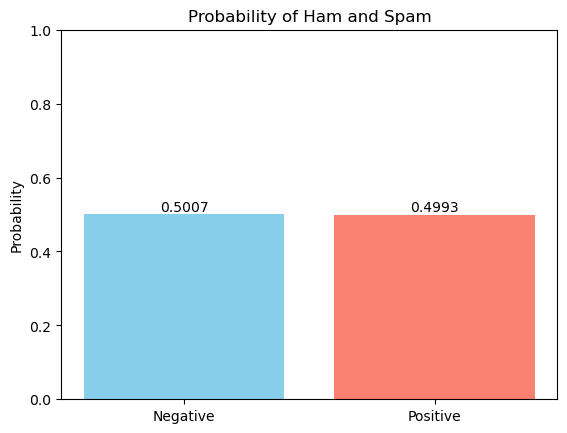

In [78]:
import matplotlib.pyplot as plt

# TODO: estimate p(S), display in bar chart
p_positve = np.mean(y)
p_negative = 1 - p_positve


# Creating the plot
labels = ['Negative', 'Positive']
values = [p_negative, p_positve]

fig, ax = plt.subplots()
bars = ax.bar(labels, values, color=['skyblue', 'salmon'])

# Adding value labels on top of each bar
for bar in bars:
    yval = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2, yval, round(yval, 4), ha='center', va='bottom')

# Adding titles and labels
ax.set_ylabel('Probability')
ax.set_title('Probability of Ham and Spam')
plt.ylim(0, 1)  # Set y-axis limits to show probabilities clearly from 0 to 1
plt.show()

### 2.4 Transform Data
Find a way to transform the features `X` (tweets) and the labels `Y` (positive/negative) into numerical representations for logistic regression.

In [79]:
vectorizer_log_reg = TfidfVectorizer(ngram_range=(1, 5), min_df = 3)
x = vectorizer_log_reg.fit_transform(X)
x_sparse = csr_matrix(x)

### 2.5 Split Data
Divide the processed data into training and testing sets to ensure that the model can be trained and validated effectively.

In [80]:
X_train, X_test, y_train, y_test = train_test_split(x_sparse, y, test_size=DATA_SPLIT_RATIO, random_state=42)

### 2.6 Train and Evaluate Model
Train a logistic regression model on the training data and evaluate its performance on the testing set using predefined metrics.

In [81]:
model_log_reg = LogisticRegression(max_iter=1000)
start_time = time.time()
model_log_reg.fit(X_train, y_train)
end_time = time.time()
training_time = end_time - start_time

y_pred = model_log_reg.predict(X_test)
evaluate_model('Logistic Regression', DATA_SIZE_LOG_REG, y_test, y_pred, training_time)

## 3. Naive Bayes
Naive Bayes is a simple yet powerful probabilistic classifier based on applying Bayes' theorem with strong independence assumptions between the features. It is particularly suited for large datasets and text classification tasks like sentiment analysis. In this section, we will prepare the data, transform it into a suitable numerical format, apply Naive Bayes to estimate the likelihoods of different classes, and evaluate the classifier’s performance. Our goal is to efficiently categorize tweets into positive or negative sentiments using the characteristics of Naive Bayes and assess its effectiveness in real-world scenarios.
### 3.1 Import Data
Prepare the dataset by loading it and processing the features (tweets) and labels (positive/negative) to make them suitable for Naive Bayes.


In [82]:
# TODO: load data, transform into numerical features + labels
df = pd.read_csv('data.csv', names=['labels', 'tweets'], header=None, skiprows=1)
# Select the first 10,000 data points
df = df.head(DATA_SIZE_NAV_BAY)

# Extract features and labels
X = df['tweets']
y = df['labels']

X = X.apply(clean_tweet)

### 3.2 Transform Data
Convert the cleaned tweet texts into a numerical format that is amenable to Naive Bayes classification.


In [83]:
vectorizer_naive_bayes = CountVectorizer(max_features=MAX_FEATURES)
x_sparse = vectorizer_naive_bayes.fit_transform(X).toarray()

### 3.3 Likelihood p(W|S)

The likelihood distribution models how likely a tweets is, given we know its either positive or negative.

\text{tweet}]$ we would expect something like 
\begin{align}
p(W|S=\text{positive}) &= \text{low}\\
p(W|S=\text{negative}) &= \text{medium}\\
\end{align}

However to estimate $p(W|S)$ we would need a dataset with the exact same $W$ appearing in both contexts: positive and negative. Since this is not the case for our dataset, this is the part where we make a naive assumption:
\begin{align}
p(W|S) = \prod_{w\in W}p(w|S)
\end{align}
That is, we consider each word in the tweet independend of the others. This simplification enables us to estimate the likelihood, since single words to in fact appear in both contexts.

For a single word $w$, we can again estimate the probability as relative frequency 
\begin{align}
p(w|S = \text{positive})_{ML} &= \cfrac{\text{\# word $w$ is labeled posotive}}{\text{\# any word is labeled positive}}\\
p(w|S = \text{negative})_{ML} &= \cfrac{\text{\# word $w$ is labeled negative}}{\text{\# any word is labeled negative}}\\
\end{align}

Since we cannot expect every word to have appeared in a positive and negative tweet, we will smooth our dataset with a [Laplace smoothing](https://en.wikipedia.org/wiki/Additive_smoothing) of $\varepsilon = 0.001$. 

This is done by adding $\varepsilon$ to the count of every word in every SMS.

As an example the count vector for a SMS over a vocabulary of 5 words is transformed from
\begin{align}
[1, 2, 0, 0, 1]
\end{align}
into
\begin{align}
[1.001, 2.001, 0.001, 0.001, 1.001]\,.
\end{align}

This way we do not have zero probabilities in the product for calculating $p(W|S)$.

In [84]:
x_smooth = x_sparse + 0.001

### 3.4 NaiveBayesClassifier
Define and initialize the Naive Bayes Classifier with methods for fitting to the data, predicting labels, and calculating accuracy.

In [85]:
class NaiveBayesClassifier():
    def __init__(self, laplace_smoothing_constant: float = 0.0001):
        """Class for binary naive Bayes."""

        self.laplace_regularization_constant = laplace_smoothing_constant
        # n_labels x n_words
        self.log_p_word_given_label: npt.NDArray[np.float64] = None
        # n_labels
        self.log_p_label: npt.NDArray[np.float64] = None

    def fit(self, x: npt.NDArray[np.float64], y: npt.NDArray[np.bool_]) -> Self:
        """Given a dataset of count vectors, calculates probabilities needed for prediction.

        Parameters
        ----------
        x : npt.NDArray[np.float64]
            Word count matrix (n_sms x n_words).
        y : npt.NDArray[np.bool_]
            Label matrix (n_sms).
        """
        
        # TODO: implement
        self.log_p_label= [np.log(np.sum(y)/ len(y)), np.log(1-np.sum(y)/ len(y))]
        x_smooth=x+self.laplace_regularization_constant
        spam_words= x_smooth[y==1].sum(axis=0)
        ham_words= x_smooth[y==0].sum(axis=0)
        self.log_p_word_given_label= np.array([[np.log(spam_words[i]/np.sum(spam_words)) for i in range(x.shape[1])], 
                                      [np.log(ham_words[i]/np.sum(ham_words)) for i in range(x.shape[1])]])
        return self

    def predict(self, x):
        """Given a dataset of count vectors, predicts labels.

        Parameters
        ----------
        x : csr_matrix of shape (n_samples, n_features)
            The input data as a sparse matrix.

        Returns
        -------
        predictions : np.ndarray of shape (n_samples,)
            Vector of predictions for labels (0 = ham, 1 = spam).
        """

        spam = []
        ham = []

        for i in range(x.shape[0]):
            non_zero_indices = x[i].nonzero()[0]
            spam_sum = np.sum(self.log_p_word_given_label[0, non_zero_indices]) + self.log_p_label[0]
            ham_sum = np.sum(self.log_p_word_given_label[1, non_zero_indices]) + self.log_p_label[1]

            spam.append(spam_sum)
            ham.append(ham_sum)

        return np.array(spam) >= np.array(ham)
        

    def accuracy(self, x: npt.NDArray[np.float64], y: npt.NDArray[np.bool_]) -> float:
        """Calculates accuracy for given dataset.

        Parameters
        ----------
        x : npt.NDArray[np.float64]
            Word count matrix (n_sms x n_words).
        y : npt.NDArray[np.bool_]
            Vector of true labels (0 = ham, 1 = spam).

        Returns
        -------
        float
            Percentage of correctly classified x.
        """

        # TODO: implement
        return np.sum(np.where(self.predict(x)==y, 1, 0))/len(y)


In [86]:
X_train, X_test, y_train, y_test = train_test_split(x_sparse, y, test_size=0.1, random_state=42)

### 3.5 Compute Model
Train the Naive Bayes model and evaluate its performance on a held-out test set.

In [87]:
# Model training with Naive Bayes approach
model_naive_bayes = NaiveBayesClassifier(laplace_smoothing_constant=LAPLACE_SMOOTHING_CONSTANT)
start_time = time.time()
model_naive_bayes.fit(X_train, y_train)
end_time = time.time()
training_time = end_time - start_time
y_pred = model_naive_bayes.predict(X_test)
evaluate_model('Naive Bayes', DATA_SIZE_NAV_BAY, y_test, y_pred, training_time)

## 4. SVM
Support Vector Machines (SVM) are a robust set of supervised learning methods used for classification, regression, and outliers detection. Ideal for high-dimensional spaces, SVM is particularly effective where the number of dimensions exceeds the number of samples. This section will guide through the steps of loading and processing data, transforming it for SVM use, training an SVM model with a linear kernel, and evaluating its performance in classifying tweets into positive or negative sentiments.
### 4.1 Import Data
Load the dataset and preprocess it to extract clean, numerical features and labels suitable for SVM classification.

In [88]:
# TODO: load data, transform into numerical features + labels
df = pd.read_csv('data.csv', names=['labels', 'tweets'], header=None, skiprows=1)
# Select the first 10,000 data points
df = df.head(DATA_SIZE_SVM)

# Extract features and labels
X = df['tweets']
y = df['labels']

X = X.apply(clean_tweet)

### 4.2 Transform Data
Apply CountVectorizer to convert text data into a sparse matrix of token counts, then split the data into training and testing sets.



In [89]:
vectorizer_svm = CountVectorizer(max_features=MAX_FEATURES)
x_sparse = vectorizer_svm.fit_transform(X).toarray()

In [90]:
X_train, X_test, y_train, y_test = train_test_split(x_sparse, y, test_size=DATA_SPLIT_RATIO, random_state=42)

### 4.3 Compute Model
Train the SVM classifier using a linear kernel and evaluate its effectiveness in classifying tweet sentiments.

In [91]:
model_svm = LinearSVC()
start_time = time.time()
model_svm.fit(X_train, y_train)
end_time = time.time()
training_time = end_time - start_time

y_pred = model_svm.predict(X_test)
evaluate_model('SVM', DATA_SIZE_SVM, y_test, y_pred, training_time)

/usr/lib/python3/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


## 5. Evaluate Model
In this final step of our analysis, we evaluate and compare the performance of our models: Logistic Regression, Naive Bayes, and SVM. We'll measure each model's accuracy, recall, precision, and F1 score, and display these metrics in both tabular and graphical formats. This comprehensive evaluation helps us understand the strengths and weaknesses of each approach in sentiment analysis.
### 5.1 Performance Analysis
Review and compare the performance of all trained models across multiple metrics to determine which model performs best for our sentiment analysis task.

In [92]:
for result in results:
    print(f"Model: {result['model']}")
    print(f"Size:  {result['model_size']}")
    print(f"Accuracy: {result['accuracy']}")
    print(f"Recall: {result['recall']}")
    print(f"Precision: {result['precision']}")
    print(f"F1 Score: {result['f1_score']}")
    print("Confusion Matrix:")
    for row in result['confusion_matrix']:
        print(row)
    print(f"Training Time: {result['time_meassured']}")
    print("-" * 40)

Model: Logistic Regression
Size:  50000
Accuracy: 0.7828
Recall: 0.7837837837837838
Precision: 0.7844073190135242
F1 Score: 0.7840954274353875
Confusion Matrix:
[1942  542]
[ 544 1972]
Training Time: 0.4725804328918457
----------------------------------------
Model: Naive Bayes
Size:  50000
Accuracy: 0.7676
Recall: 0.7416534181240063
Precision: 0.7846930193439865
F1 Score: 0.7625664078463424
Confusion Matrix:
[1972  512]
[ 650 1866]
Training Time: 3.3984155654907227
----------------------------------------
Model: SVM
Size:  50000
Accuracy: 0.76
Recall: 0.7778219395866455
Precision: 0.7532717474980755
F1 Score: 0.7653500195541652
Confusion Matrix:
[1843  641]
[ 559 1957]
Training Time: 7.083224534988403
----------------------------------------


### 5.2 Visualize Results
Create a visual comparison of the performance metrics for each model to facilitate a quick assessment of their effectiveness.

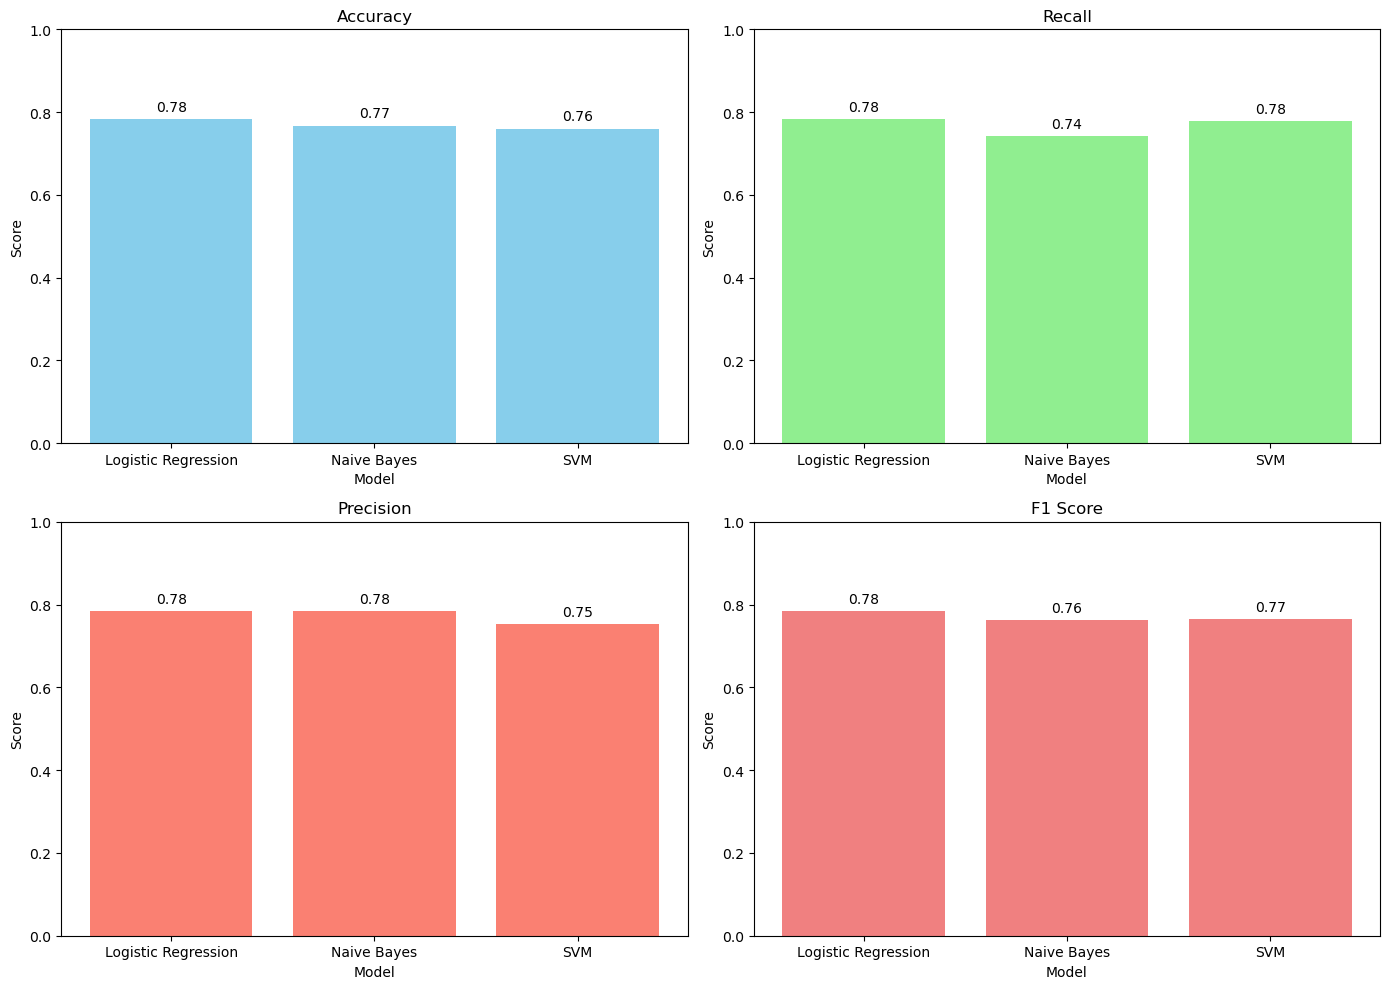

In [93]:
def plot_metrics(results):
    models = [result['model'] for result in results]
    accuracies = [result['accuracy'] for result in results]
    recalls = [result['recall'] for result in results]
    precisions = [result['precision'] for result in results]
    f1_scores = [result['f1_score'] for result in results]

    fig, axs = plt.subplots(2, 2, figsize=(14, 10))

    # Accuracy plot
    axs[0, 0].bar(models, accuracies, color='skyblue')
    axs[0, 0].set_title('Accuracy')
    axs[0, 0].set_ylim([0, 1])
    for i, v in enumerate(accuracies):
        axs[0, 0].text(i, v + 0.02, f"{v:.2f}", ha='center')

    # Recall plot
    axs[0, 1].bar(models, recalls, color='lightgreen')
    axs[0, 1].set_title('Recall')
    axs[0, 1].set_ylim([0, 1])
    for i, v in enumerate(recalls):
        axs[0, 1].text(i, v + 0.02, f"{v:.2f}", ha='center')

    # Precision plot
    axs[1, 0].bar(models, precisions, color='salmon')
    axs[1, 0].set_title('Precision')
    axs[1, 0].set_ylim([0, 1])
    for i, v in enumerate(precisions):
        axs[1, 0].text(i, v + 0.02, f"{v:.2f}", ha='center')

    # F1 Score plot
    axs[1, 1].bar(models, f1_scores, color='lightcoral')
    axs[1, 1].set_title('F1 Score')
    axs[1, 1].set_ylim([0, 1])
    for i, v in enumerate(f1_scores):
        axs[1, 1].text(i, v + 0.02, f"{v:.2f}", ha='center')

    for ax in axs.flat:
        ax.set_xticks(range(len(models)))
        ax.set_xticklabels(models)
        ax.set_xlabel('Model')
        ax.set_ylabel('Score')

    plt.tight_layout()
    plt.show()
# Plot the metrics
plot_metrics(results)

### 5.3 Save the results data

In [94]:

def save_results(results, model_size):
    # Convert the list of dictionaries to a DataFrame
    df = pd.DataFrame(results)

    # Generate the file name based on model_size
    file_name = f'performance_result_{model_size}.csv'

    # Save the DataFrame to a CSV file
    df.to_csv(file_name, index=False)
save_results(results, DATA_SIZE_LOG_REG)

## 6. Valadation Data Set
This section is dedicated to validating our trained models using a new, unseen dataset. Validation is crucial as it provides an unbiased evaluation of a model, reflecting its performance in real-world scenarios. We will import the validation data, preprocess it, transform it into the required format for our model, and finally predict labels to assess how well our model generalizes to new data.

### 6.1 Import Training Data and Train Model
Train the logistic regression model with all 500 000 tweets.

In [95]:
# TODO: load data, transform into numerical features + labels
df = pd.read_csv('data.csv', names=['labels', 'tweets'], header=None, skiprows=1)
df = df.head(500_000)

# Extract features and labels
X_train = df['tweets']
y_train = df['labels']

X_train = X_train.apply(clean_tweet)

In [96]:
vectorizer_log_reg = TfidfVectorizer(ngram_range=(1, 5), min_df = 3)
x_train = vectorizer_log_reg.fit_transform(X_train)
x_sparse_train = csr_matrix(x_train)

### 6.2 Import Validation Data
Load the external validation dataset and preprocess the tweets to align with the data used to train the model.

In [97]:
# Assuming the necessary functions and model are already defined
df_validation = pd.read_csv('data_validation.csv', names=['tweets'], header=None, skiprows=1)
df_validation = df_validation.head(100000)


# Extract features and labels
X = df_validation['tweets']
X = X.apply(clean_tweet)

### 6.3 Train Model
Train a logistic regression model on the training data.

In [98]:
model_log_reg = LogisticRegression(max_iter=1000)
model_log_reg.fit(x_sparse_train, y_train)

LogisticRegression(max_iter=1000)

### 6.4 Transform Validation Data
Transform the cleaned tweets from the validation set into the numerical format expected by the logistic regression model.

In [99]:
x_validation_log_reg = vectorizer_log_reg.transform(X)
x_sparse_log_reg = csr_matrix(x_validation_log_reg)

In [100]:
x_validation_naive_bayes = vectorizer_naive_bayes.transform(X)

In [101]:
x_validation_svm = vectorizer_svm.transform(X)
x_validation_svm_dense = x_validation_svm.toarray()

### 6.5 Predict Data
Predict the sentiment labels using the logistic regression model on the transformed validation data

In [102]:
y_pred_log_reg = model_log_reg.predict(x_sparse_log_reg)
y_pred_naive_bayes = model_naive_bayes.predict(x_validation_naive_bayes)
y_pred_svm = model_svm.predict(x_validation_svm_dense)

np.save('solution_logistic_regression.npy', y_pred_log_reg)
np.save('solution_naive_bayes.npy', y_pred_naive_bayes)
np.save('solution_svm.npy', y_pred_svm)

# To verify, you can load the file and print the contents
labels_log_reg = np.load('solution_logistic_regression.npy')
labels_naive_bayes = np.load('solution_naive_bayes.npy')
labels_svm = np.load('solution_svm.npy')